# cVQ-GAN For Impressionist Art

Sami Muduroglu, Colin McGravey, Will O'Brien, and Josh Freud.

## Step 1: Download necessary libraries and dataset

In [60]:
import glob as glob
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

## Step 2: Preprocessing the Data

##### A - Grab CSV files 
- We have to merge dataframes on 'artist' column to have access to the period 
- After merging, we remove unnecessary columns and works that are not in the desired periods

##### B - Open all image files and convert to Tensors

- Some files have a different color mechanism than the majority, so we must skip over all images that have a shape of [1, 64, 64] after being converted to Tensors.
- This cell will take about 5 minutes to run completely

In [61]:
# Grab artwork csv 
fpath = './artwork_dataset.csv'
artwork_df = pd.read_csv(fpath)

# Grab info csv 
fpath = './info_dataset.csv'
info_df = pd.read_csv(fpath)

# Merge on artist name
art_data = pd.merge(artwork_df, info_df, on='artist', how='outer')
columns_to_drop = ['title', 'picture data', 'file info', 'school', 'born-died', 'base', 'nationality', 'url']
art_data = art_data.drop(columns=columns_to_drop)

periods = ['Baroque', 'Rococo', 'Mannerism', 'Romanticism']
dfs = []

# Place artwork from four specific periods in their own dataframes
for period in periods:
    df = art_data[art_data['period'] == period]
    dfs.append(df)

# Define target size and data array
imgs_and_labels = []
target_size = 128

# Define the data transformations
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))  # Normalize the pixel values to the range [-1, 1]
])

# Iterate through dataframes and preprocess images
for df in dfs:
    df_arr = df.values
    for entry in df_arr:
        img = Image.open(f'./artwork/{str(entry[0])}.jpg')
        img = img.resize((target_size, target_size))
        img = np.asarray(img)
        img = transforms(img)

        if entry[3] == 'Baroque':
            label = 0
        elif entry[3] == 'Rococo': 
            label = 1
        elif entry[3] == 'Mannerism': 
            label = 2
        else:
            label = 3

        label = torch.tensor(label)

        # If tensor size is not compatible, pass over it
        if img.shape == torch.Size([1, target_size, target_size]):
            pass
        else:
            imgs_and_labels.append({"img": img, "label": label})

print(f'Number of Images: {len(imgs_and_labels)}')



##### Define Image Dataset Class

In [ ]:
# Define Image Dataset class 
class ImageDataset(Dataset):
    def __init__(self, imgs, train=True, test_size=0.2):
        self.imgs = imgs
        self.train_imgs, self.test_imgs = train_test_split(self.imgs, test_size=test_size, random_state=42)
        self.train = train

    # Return lengths of train and test sets 
    def __len__(self):
        if self.train:
            return len(self.train_imgs)
        else:
            return len(self.test_imgs)
    
    # Retrieve next item from dataset 
    def __getitem__(self, idx):
        if self.train:
            img = self.train_imgs[idx]["img"]
            label = self.train_imgs[idx]["label"]
        else:
            img = self.test_imgs[idx]["img"]
            label = self.test_imgs[idx]["label"]
        
        return img, label

##### Setup Datasets and Dataloaders

In [ ]:
# Set up Datasets 
train_data = ImageDataset(imgs_and_labels, train=True, test_size=0.15)
test_data = ImageDataset(imgs_and_labels, train=False, test_size=0.15)

# Set up Dataloaders 
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Check number of images in training and test datasets 
print('Number of training images {}, number of testing images {}'.format(len(train_data), len(test_data)))

Number of training images 18645, number of testing images 3291


##### Preview a few of the image files

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


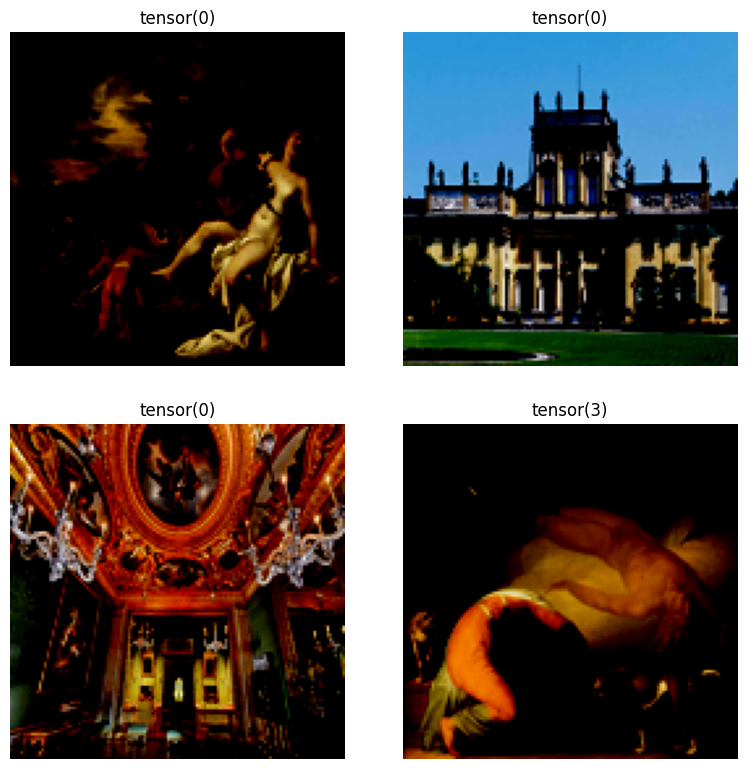

In [ ]:
imgs = []
labels = []

for images, labels in train_loader:
    imgs = images[:4]
    labels = labels[:4]
    break

# Create a 2x2 grid for plotting
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
fig.tight_layout()

# Plot each image with its corresponding label as title
for i in range(len(imgs)):
    reshaped_image = np.transpose(imgs[i], (1, 2, 0))
    ax = axs[i // 2][i % 2]  # Get the subplot
    ax.imshow(reshaped_image)  # Display the image
    ax.set_title(labels[i])  # Set the label as title

# Hide axes if needed
for ax in axs.flat:
    ax.axis('off')

## Step 2: Build Generator and Discriminator

In [ ]:
class Generator(nn.Module):
    def __init__(self, classes=4, channels=3, img_size=64, latent_dim=100):
        super(Generator, self).__init__()

        self.classes = classes
        self.channels = channels
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.img_shape = (self.channels, self.img_size, self.img_size)

        self.latent_prep = nn.Sequential(
            nn.Linear(self.latent_dim, 4*4*512), 
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.label_prep = nn.Sequential(
            nn.Embedding(self.classes, self.latent_dim),
            nn.Linear(self.latent_dim, 16)
        )

        self.model = nn.Sequential(
            nn.ConvTranspose2d(513, 64*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1,bias=False),
            nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
            nn.ReLU(True), 
            nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1,bias=False),
            nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
            nn.ReLU(True), 
            nn.ConvTranspose2d(64*2, 64*1, 4, 2, 1,bias=False),
            nn.BatchNorm2d(64*1, momentum=0.1,  eps=0.8),
            nn.ReLU(True), 
            nn.ConvTranspose2d(64*1, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, label):             
        label_output = self.label_prep(label)
        label_output = label_output.view(-1, 1, 4, 4)

        ## print(f'Label Output: {label_output.shape}')

        latent_output = self.latent_prep(noise)
        latent_output = latent_output.view(-1, 512,4,4)

        ## print(f'Latent Output: {latent_output.shape}')

        concat = torch.cat((latent_output, label_output), dim=1)
        image = self.model(concat)
        return image

##### Declare generator and test it with input

In [ ]:
netG = Generator(classes=4, channels=3, img_size=128, latent_dim=100)

with torch.no_grad():
    for images, labels in train_loader:
        labels = labels.unsqueeze(1).long()
        noise = torch.randn((64, 100))
        output = netG(noise, labels)
        print(output.shape)
        break

torch.Size([64, 3, 128, 128])


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, classes=4, channels=3, img_size=128, latent_dim=100):
        super(Discriminator, self).__init__()

        self.classes = classes
        self.channels = channels
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.img_shape = (self.channels, self.img_size, self.img_size)

        self.label_prep = nn.Sequential(
            nn.Embedding(self.classes, self.latent_dim),
            nn.Linear(self.latent_dim, 3*128*128)
        )

        self.model = nn.Sequential(
            nn.Conv2d(6, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64*2, 4, 3, 2, bias=False),
            nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64*2, 64*4, 4, 3,2, bias=False),
            nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64*4, 64*8, 4, 3, 2, bias=False),
            nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
            nn.LeakyReLU(0.2, inplace=True), 
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(4608, 1),
            nn.Sigmoid()
        )

    def forward(self, images, labels):
        label_output = self.label_prep(labels)
        label_output = label_output.view(-1, 3, 128, 128)
        concat = torch.cat((images, label_output), dim=1)
        output = self.model(concat)
        return output

In [ ]:
netD = Discriminator()

with torch.no_grad(): 
    for images, labels in train_loader: 
        labels = labels.unsqueeze(1).long()
        output = netD(images, labels)
        print(output.shape)
        break

torch.Size([64, 1])


##### Define loss functions and optimizers

In [ ]:
binary_cross_entropy = torch.nn.BCELoss()

def generator_loss(label, fake_output):
    gen_loss = binary_cross_entropy(label, fake_output)
    return gen_loss

def discriminator_loss(label, output):
    disc_loss = binary_cross_entropy(label, output)
    return disc_loss

learning_rate = 0.0002
G_optimizer = optim.Adam(netG.parameters(), lr = learning_rate, betas=(0.5, 0.999))
D_optimizer = optim.Adam(netD.parameters(), lr = learning_rate, betas=(0.5, 0.999))


## Step 3: Train Network

In [ ]:
num_epochs = 200
for epoch in range(1, num_epochs+1): 
 
    D_loss_list, G_loss_list = [], []
    
    for index, (real_images, labels) in enumerate(train_loader):
        D_optimizer.zero_grad()
        real_images = real_images
        labels = labels
        labels = labels.unsqueeze(1).long()
 
       
        real_target = torch.ones(real_images.size(0), 1)
        fake_target = torch.zeros(real_images.size(0), 1)
       
        D_real_loss = discriminator_loss(netD(real_images, labels), real_target)
        # print(discriminator(real_images))
        #D_real_loss.backward()
        
        noise_vector = torch.randn(real_images.size(0), 100)  
        noise_vector = noise_vector
         
        
        generated_image = netG(noise_vector, labels)
        output = netD(generated_image.detach(), labels)
        D_fake_loss = discriminator_loss(output,  fake_target)
 
     
        # train with fake
        #D_fake_loss.backward()
       
        D_total_loss = (D_real_loss + D_fake_loss) / 2
        D_loss_list.append(D_total_loss)
       
        D_total_loss.backward()
        D_optimizer.step()
 
        # Train generator with real labels
        G_optimizer.zero_grad()
        G_loss = generator_loss(netD(generated_image, labels), real_target)
        G_loss_list.append(G_loss)
 
        G_loss.backward()
        G_optimizer.step()

KeyboardInterrupt: 

## Step 4: Test

## Step 5: Analyze